In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon ## for polygons
import baltic as bt
import re
import pandas as pd
import numpy as np
from matplotlib.collections import PatchCollection ## for polygons too
from matplotlib import gridspec ## for composite figures

import warnings
warnings.filterwarnings("ignore")

from matplotlib.patches import Patch

import math
import time
import sys
import unicodedata
# import unidecode ## for removing diacritics from example geoJSON

import json ## used for importing JSONs
try:
    from StringIO import StringIO as sio
    from cStringIO import StringIO as csio
except ImportError:
    from io import StringIO as sio
    from io import BytesIO as csio
    
def removeDiacritics(string):
    """
    Removes diacritic marks from unicode.
    """
    return unicodedata.normalize('NFKD', string)

try:
    from itertools import product
except ImportError:
    # product is new in v 2.6
    def product(*args, **kwds):
        pools = map(tuple, args) * kwds.get('repeat', 1)
        result = [[]]
        for pool in pools:
            result = [x+[y] for x in result for y in pool]
        for prod in result:
            yield tuple(prod)

----

# Distribution maps for Lepidocaryeae species

----

### Species included belong to the genera:

- Raphia
- Eremospatha
- Laccosperma
- Oncocalamus
- Mauritiella
- Mauritia
- Lepidocaryum

1534 records + Coordinates from Eduardo Prata


# 1. Get clean GBIF coordinates to plot hexagon bins and filter out records with no indetifier ID

These GBIF records were cleaned with CoordinateCleaner ([Zizka et al. 2019](https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/2041-210X.13152)), removing coordinates falling on bodies of water, near institutions, country centroids, etc. Records outside the native botanical countries registered for the species were removed with scripts in this same repository. Then, we used grep to select records matching any of the genus above.

**Citation** GBIF.org (04 March 2021) GBIF Occurrence Download https://doi.org/10.15468/dl.pqvthv


### Important header fields

In 1 indexing (when using cut and awk)
1. gbifID
6. class
7. order
8. family
9. genus
10. species
11. infraspecificEpithet
16. countryCode
17. locality
22. decimalLatitude
23. decimalLongitude
37. institutionCode
41. identifiedBy
46. typeStatus
49. issue

### 1.1 Bash cleaning

In [ ]:
%%bash
# get rid of fossils
grep -v 'fossil' gbif_arecaceae_20210304.csv > gbif_arecaceae_nofosil_20210304.csv

# check encoding
file -bi gbif_arecaceae_nofosil_20210304.csv
# text/plain; charset=utf-8   yet... there are extra taaaabbss!!!

# transform file into UTF-8 or else suffer
# iconv options -f from-encoding -t to-encoding inputfile(s) -o outputfile 
# iconv -f UTF-8 -t UTF-8//TRANSLIT gbif_arecaceae_nofosil_20210304.csv > gbif_arecaceae_nofosil_utf8_20210304.csv
# file -bi gbif_arecaceae_nofosil_utf8_20210304.csv
# text/plain; charset=utf-8   yet... there are extra taaaabbss!!!

# extract records matching to Lepidocaryeae genera
# some fields are moved and the genus is on the species column
head -n 1 gbif_arecaceae_20210304.csv > gbif_arecaceae_nofosil_lep_20210304.csv
while IFS='' read -r line || [[ -n "$line" ]]; do
    awk -v var="$line" '$9==var || $10==var {print}' gbif_arecaceae_nofosil_20210304.csv >> gbif_arecaceae_nofosil_lep_20210304.csv
done < lepido_genera.txt

# count number of fields per line
cat gbif_arecaceae_nofosil_lep_20210304.csv | awk '{FS="\t"}; {print NF}' | hist -b 10 -x

# lines ruining my life -- extra fields
# who is it??
cat gbif_arecaceae_nofosil_lep_20210304.csv | awk '{FS="\t"}; NF==51 {print}{}' 
# 2563611121      50c9509d-22c7-4a22-a47d-8c48425ef4a7 # I'll remove it. 
grep -v '50c9509d-22c7-4a22-a47d-8c48425ef4a7' gbif_arecaceae_nofosil_lep_20210304.csv > gbif_lepido_20210304.csv

### 1.2 Load data and remove rows without coordinates

In [2]:
gbifall=pd.read_csv('./gbif_lepido_20210304.csv',sep='\t')#,names=header,index_col='index')
gbifall

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
0,1321555998,821cc27a-e3bb-4bc5-ac34-89ada245069d,http://n2t.net/ark:/65665/3c0856ad6-b284-4bc5-...,Plantae,Tracheophyta,Liliopsida,Arecales,Arecaceae,Raphia,Raphia taedigera,...,NaN,NaN,CC0_1_0,NaN,F. L. Stevens,NaN,NaN,2021-02-27T10:50:17.410Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
1,437986376,b5cdf794-8fa4-4a85-8b26-755d087bf531,http://coldb.mnhn.fr/catalognumber/mnhn/p/p004...,Plantae,Tracheophyta,Liliopsida,Arecales,Arecaceae,Raphia,NaN,...,NaN,NaN,CC_BY_4_0,NaN,"Florence, J.",NaN,NaN,2021-03-03T12:56:15.612Z,StillImage,NaN
2,1019605122,b5cdf794-8fa4-4a85-8b26-755d087bf531,http://coldb.mnhn.fr/catalognumber/mnhn/p/p021...,Plantae,Tracheophyta,Liliopsida,Arecales,Arecaceae,Raphia,NaN,...,NaN,NaN,CC_BY_4_0,NaN,NaN,NaN,NaN,2021-03-03T12:56:21.549Z,StillImage,TAXON_MATCH_HIGHERRANK
3,464777062,b5cdf794-8fa4-4a85-8b26-755d087bf531,http://coldb.mnhn.fr/catalognumber/mnhn/p/p017...,Plantae,Tracheophyta,Liliopsida,Arecales,Arecaceae,Raphia,Raphia hookeri,...,NaN,NaN,CC_BY_4_0,NaN,NaN,NaN,NaN,2021-03-03T12:56:06.533Z,StillImage,NaN
4,465018691,b5cdf794-8fa4-4a85-8b26-755d087bf531,http://coldb.mnhn.fr/catalognumber/mnhn/p/p019...,Plantae,Tracheophyta,Liliopsida,Arecales,Arecaceae,Raphia,Raphia vinifera,...,NaN,NaN,CC_BY_4_0,NaN,NaN,NaN,NaN,2021-03-03T12:55:38.462Z,StillImage,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49291,1260262574,7bd65a7a-f762-11e1-a439-00145eb45e9a,urn:catalog:MO:Tropicos:290157,Plantae,Tracheophyta,Liliopsida,Arecales,Arecaceae,Lepidocaryum,NaN,...,NaN,NaN,CC_BY_4_0,Missouri Botanical Garden,Thomas B. Croat,NaN,NaN,2021-03-02T09:24:16.413Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
49292,1260221567,7bd65a7a-f762-11e1-a439-00145eb45e9a,urn:catalog:MO:Tropicos:286412,Plantae,Tracheophyta,Liliopsida,Arecales,Arecaceae,Lepidocaryum,Lepidocaryum tenue,...,R. Bernal (COL),1999-01-01T00:00:00,CC_BY_4_0,Missouri Botanical Garden,Agustin Rudas L.|Adriana Prieto,NaN,NaN,2021-03-02T09:23:28.145Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
49293,1260252209,7bd65a7a-f762-11e1-a439-00145eb45e9a,urn:catalog:MO:Tropicos:289221,Plantae,Tracheophyta,Liliopsida,Arecales,Arecaceae,Lepidocaryum,Lepidocaryum tenue,...,A. Anderson (NY),1987-01-01T00:00:00,CC_BY_4_0,Missouri Botanical Garden,Sandy Knapp|Jim Mallet,NaN,NaN,2021-03-02T09:22:10.204Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
49294,1260247882,7bd65a7a-f762-11e1-a439-00145eb45e9a,urn:catalog:MO:Tropicos:288827,Plantae,Tracheophyta,Liliopsida,Arecales,Arecaceae,Lepidocaryum,Lepidocaryum tenue,...,NaN,NaN,CC_BY_4_0,Missouri Botanical Garden,Alwyn H. Gentry|Rodolfo Vásquez|Nestor Jaramillo,NaN,NaN,2021-03-02T09:24:14.495Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...


In [3]:
gbifall[['decimalLatitude', 'decimalLongitude']].isna().describe()

,decimalLatitude,decimalLongitude
count,49296,49296
unique,2,2
top,False,False
freq,45355,45355


In [4]:
gbifallcord=gbifall[~gbifall['decimalLatitude'].isna()]
gbifallcord[['decimalLatitude', 'decimalLongitude']].isna().describe()

,decimalLatitude,decimalLongitude
count,45355,45355
unique,1,1
top,False,False
freq,45355,45355


### 1.4 Remove species with no 'identify by' field

In [5]:
gbifallcord.columns
gbifallcord[['basisOfRecord','institutionCode','identifiedBy','recordedBy']].isna().describe()

,basisOfRecord,institutionCode,identifiedBy,recordedBy
count,45355,45355,45355,45355
unique,1,2,2,2
top,False,False,False,True
freq,45355,44183,40863,40766


In [6]:
# recordedby has more empties than identifiedby. Let's work with identifyby and check unique names
gbifallcord['identifiedBy'].unique()
# there are a few fields we need to get rid off that are obvious
remove=[np.nan, 'nan','Anónimo','lattes.cnpq.br/3843526011662634','SIN','RRC ID Flag']
gbifallcordid=gbifallcord[~gbifallcord['identifiedBy'].isin(remove)]
gbifallcordid[['basisOfRecord','institutionCode','identifiedBy','recordedBy']].isna().describe()

,basisOfRecord,institutionCode,identifiedBy,recordedBy
count,40719,40719,40719,40719
unique,1,2,1,2
top,False,False,False,True
freq,40719,39911,40719,38746


### 1.5 Check out species names

In [7]:
gbifallcordid[['genus','species','scientificName','infraspecificEpithet','verbatimScientificName']].isna().describe() # all false

,genus,species,scientificName,infraspecificEpithet,verbatimScientificName
count,40719,40719,40719,40719,40719
unique,1,2,1,2,1
top,False,False,False,False,False
freq,40719,40638,40719,33598,40719


In [8]:
import time
gbifallcordid['scientificName'].unique()
# some species are missing from the 'species' column but present in the 'scientificName' column
# grep species name and assign it into a new columns
# gbifallcord['spp_assigned']=''
for row in gbifallcordid.itertuples():
    # note that this will not replace patters than don't match, likely just the genus name and author. We cannot use those coordinates anyway.
    # filtering by a list of wanted species will ignore those ones.
    species=re.sub('([A-Za-z]+) ([a-z\-]+) .*','\\1_\\2',row.scientificName)
    gbifallcordid.loc[row.Index,'spp_assigned']=species if '_' in species else np.nan
gbifallcordid[['scientificName','spp_assigned']]

,scientificName,spp_assigned
23,Raphia gracilis Becc.,Raphia_gracilis
24,Raphia hookeri G.Mann & H.Wendl.,Raphia_hookeri
25,Raphia sudanica A.Chev.,Raphia_sudanica
27,Raphia hookeri G.Mann & H.Wendl.,Raphia_hookeri
28,Raphia hookeri G.Mann & H.Wendl.,Raphia_hookeri
...,...,...
49255,Lepidocaryum tenue Mart.,Lepidocaryum_tenue
49280,Lepidocaryum tenue Mart.,Lepidocaryum_tenue
49287,Lepidocaryum tenue Mart.,Lepidocaryum_tenue
49292,Lepidocaryum tenue Mart.,Lepidocaryum_tenue


In [9]:
# number of unique species left
gbifallcordidspp=gbifallcordid[~gbifallcordid['spp_assigned'].isna()]
print('Number of species: ',len(gbifallcordidspp['spp_assigned'].unique()),'\n')
print(gbifallcordidspp['spp_assigned'].unique())

Number of species:  50 

['Raphia_gracilis' 'Raphia_hookeri' 'Raphia_sudanica' 'Raphia_palma-pinus'
 'Raphia_regalis' 'Raphia_textilis' 'Raphia_vinifera' 'Raphia_australis'
 'Raphia_monbuttorum' 'Raphia_farinifera' 'Raphia_taedigera'
 'Raphia_mambillensis' 'Raphia_africana' 'Eremospatha_macrocarpa'
 'Eremospatha_hookeri' 'Eremospatha_dransfieldii' 'Eremospatha_laurentii'
 'Eremospatha_haullevilleana' 'Eremospatha_cuspidata'
 'Eremospatha_wendlandiana' 'Eremospatha_cabrae'
 'Eremospatha_quinquecostulata' 'Eremospatha_barendii'
 'Eremospatha_tessmanniana' 'Ancistrophyllum_secundiflorum'
 'Laccosperma_opacum' 'Laccosperma_laeve' 'Laccosperma_secundiflorum'
 'Laccosperma_robustum' 'Laccosperma_acutiflorum' 'Ancistrophyllum_laeve'
 'Ancistrophyllum_opacum' 'Oncocalamus_mannii' 'Oncocalamus_macrospathus'
 'Oncocalamus_wrightianus' 'Oncocalamus_tuleyi' 'Mauritiella_armata'
 'Mauritiella_aculeata' 'Mauritiella_macroclada' 'Mauritiella_pumila'
 'Mauritia_pacifica' 'Mauritia_armata' 'Mauritiella

In [ ]:
# why do we have Ancistrophyllum_laeve and 'Ancistrophyllum_opacum'

### 1.6 Synonym species? Using Kew's species checklist

In [10]:
# Creating metadata dictionaries from parsing the Kew species list information
# file saved with UTF-8
# removed symbol *
kew_html_path='C:/Users/xtorrm/Documents/Palm_leaf/Native_species_to_btocountries.html'
species_areas_dict={}
species_synon_dict={}
spp_genus={}
for line in open(kew_html_path,'r',encoding="utf8"):
    # detects the species count line and doesn't take it as species line (it is genus line)
    speciescountmatch=re.search('rptDetNameSpcCount',line)
    genuscountmatch=re.search('Arecaceae',line)
    # skips lines with irrelevant information
    if speciescountmatch or genuscountmatch:
        pass
    else:
        detnamematch=re.search('rptDetName',line)
        if detnamematch:
            # fetching information
            speciesmatch=re.search('<i><b>([A-Z][a-z]+)</b><b> ([a-z-]+)</b></i>',line) # note the space
            areamatch=re.search('"rptDetNameDescription">(.+?)</p>',line)
            synonmatch=re.findall('("rptDetNameSynonyms"> <i>[A-Z][a-z]+</i><i> [a-z-]+</i>.+</p>)',line)
            
            # asigning
            species='%s_%s'%(speciesmatch.group(1),speciesmatch.group(2)) if speciesmatch else None
            genus='%s'%(speciesmatch.group(1)) if speciesmatch else None
            species_areas_dict[species]=re.findall('([A-Z][A-Z][A-Z])+',areamatch.group(0)) if areamatch else None
            
            synonyms=re.findall('([A-Z][a-z]+</i><i> [a-z-]+)</i> ',line)# if synonmatch else None
            species_synon_dict[species]=[x.replace('</i><i> ','_') for x in synonyms] if synonmatch else 'none'
            spp_genus[species]=genus
# print(species_areas_dict)
# print(species_synon_dict)
data=pd.DataFrame()
# print(list(species_areas_dict))
data['species']=list(species_areas_dict.keys())
data['areas']=data['species'].map(species_areas_dict)
data['synonyms']=data['species'].map(species_synon_dict)
data['genus']=data['species'].map(spp_genus)
data

,species,areas,synonyms,genus
0,Acanthophoenix_crinita,[REU],[Areca_crinita],Acanthophoenix
1,Acanthophoenix_rousselii,[REU],none,Acanthophoenix
2,Acanthophoenix_rubra,"[MAU, REU]","[Areca_rubra, Calamus_verschaffeltii, Sublimia...",Acanthophoenix
3,Acoelorraphe_wrightii,"[FLA, MXG, MXT, BLZ, COS, GUA, HON, NIC, BAH, ...","[Copernicia_wrightii, Paurotis_wrightii, Seren...",Acoelorraphe
4,Acrocomia_aculeata,"[MXG, MXS, MXT, BLZ, COS, ELS, GUA, HON, NIC, ...","[Cocos_aculeata, Acrocomia_sclerocarpa, Palma_...",Acrocomia
...,...,...,...,...
2530,Wettinia_quinaria,"[CLM, ECU]","[Wettinella_quinaria, Wettinia_utilis]",Wettinia
2531,Wettinia_radiata,"[PAN, CLM]","[Catostigma_radiatum, Catoblastus_radiatus, Ca...",Wettinia
2532,Wettinia_verruculosa,"[CLM, ECU]",none,Wettinia
2533,Wodyetia_bifurcata,[QLD],none,Wodyetia


In [11]:
# Check for the weird ones in the Lepido list
# why do we have Ancistrophyllum_laeve and 'Ancistrophyllum_opacum'

data[data['species'].isin(['Ancistrophyllum_laeve','Ancistrophyllum_opacum'])]

for row in data.itertuples():
    for spp in row.synonyms:
        if spp in ['Ancistrophyllum_laeve','Ancistrophyllum_opacum']:
            print(row)

Pandas(Index=1651, species='Laccosperma_laeve', areas=['GHA', 'IVO', 'LBR', 'CAB', 'CMN', 'CON', 'GAB', 'ZAI'], synonyms=['Calamus_laevis', 'Ancistrophyllum_laeve', 'Neoancistrophyllum_laeve'], genus='Laccosperma')
Pandas(Index=1652, species='Laccosperma_opacum', areas=['BEN', 'GHA', 'GUI', 'IVO', 'LBR', 'NGA', 'CAF', 'CMN', 'CON', 'EQG', 'GAB', 'GGI', 'ZAI'], synonyms=['Palmijuncus_opacus', 'Ancistrophyllum_opacum', 'Neoancistrophyllum_opacum', 'Calamus_opacus'], genus='Laccosperma')


In [12]:
# what else do we need to change?
# checking the species list we have as "accepted"
acceptedspp=data[data['genus'].isin(['Raphia','Eremospatha','Laccosperma','Oncocalamus','Mauritiella','Mauritia','Lepidocaryum'])]['species'].unique()
print('Accepted species:\n',acceptedspp,'\n')

for spp in gbifallcordidspp['spp_assigned'].unique():
    if spp not in acceptedspp:
        print('Check synonym: ',spp,'--> ',species_synon_dict.values() if spp in species_synon_dict.values() else '')
# replace the synonyms above with the 

Accepted species:
 ['Eremospatha_barendii' 'Eremospatha_cabrae' 'Eremospatha_cuspidata'
 'Eremospatha_dransfieldii' 'Eremospatha_haullevilleana'
 'Eremospatha_hookeri' 'Eremospatha_laurentii' 'Eremospatha_macrocarpa'
 'Eremospatha_quinquecostulata' 'Eremospatha_tessmanniana'
 'Eremospatha_wendlandiana' 'Laccosperma_acutiflorum'
 'Laccosperma_cristalensis' 'Laccosperma_korupense' 'Laccosperma_laeve'
 'Laccosperma_opacum' 'Laccosperma_robustum' 'Laccosperma_secundiflorum'
 'Lepidocaryum_tenue' 'Mauritia_carana' 'Mauritia_flexuosa'
 'Mauritiella_aculeata' 'Mauritiella_armata' 'Mauritiella_macroclada'
 'Mauritiella_pumila' 'Oncocalamus_macrospathus' 'Oncocalamus_mannii'
 'Oncocalamus_tuleyi' 'Oncocalamus_wrightianus' 'Raphia_africana'
 'Raphia_australis' 'Raphia_farinifera' 'Raphia_gabonica'
 'Raphia_gentiliana' 'Raphia_hookeri' 'Raphia_laurentii'
 'Raphia_longiflora' 'Raphia_mambillensis' 'Raphia_mannii'
 'Raphia_matombe' 'Raphia_monbuttorum' 'Raphia_palma-pinus'
 'Raphia_regalis' 'Raphia

Synonym or not-found spp --> accepted (According to Kew)

Check synonym:  Raphia gracilis --> Raphia palma-pinus
Check synonym:  Ancistrophyllum secundiflorum --> Laccosperma secundiflorum
Check synonym:  Ancistrophyllum laeve --> Laccosperma laeve 
Check synonym:  Ancistrophyllum opacum --> Laccosperma opacum
Check synonym:  Mauritia pacifica -->  Mauritiella macroclada
Check synonym:  Mauritia armata -->  Mauritiella armata
Check synonym:  Mauritiella cataractarum -->  Mauritiella aculeata
Check synonym:  Mauritia vinifera -->  Mauritia flexuosa
Check synonym:  Lepidocaryum allenii -->  Lepidocaryum tenue
Check synonym:  Lepidocaryum gracile -->  Lepidocaryum tenue
Check synonym:  Lepidocaryum tessmannii -->  Lepidocaryum tenue

In [13]:
changes={'Raphia_gracilis':'Raphia_palma-pinus',
'Ancistrophyllum_secundiflorum':'Laccosperma_secundiflorum',
'Ancistrophyllum_laeve':'Laccosperma_laeve',
'Ancistrophyllum_opacum':'Laccosperma_opacum',
'Mauritia_pacifica':'Mauritiella_macroclada',
'Mauritia_armata':'Mauritiella_armata',
'Mauritiella_cataractarum':'Mauritiella_aculeata',
'Mauritia_vinifera':'Mauritia_flexuosa',
'Lepidocaryum_allenii':'Lepidocaryum_tenue',
'Lepidocaryum_gracile':'Lepidocaryum_tenue',
'Lepidocaryum_tessmannii':'Lepidocaryum_tenue'}

for row in gbifallcordidspp.itertuples():
    if row.spp_assigned in changes.keys():
        gbifallcordidspp.loc[row.Index,'spp_assigned']=changes[row.spp_assigned]
        
for spp in gbifallcordidspp['spp_assigned'].unique():
    if spp not in acceptedspp:
        print('Check synonym: ',spp,'--> ',species_synon_dict.values() if spp in species_synon_dict.values() else '')
# nothing should appear!

### 1.7 Remove species not in native countries

In [14]:
json_path='C:/Users/xtorrm/Documents/Palm_gap/wgsrpd-master/geojson/level3.geojson'
json_map=json.load(open(json_path,'r'))

features=json_map['features']
location_points={} ## location points will be stored here
polygons={} ## polygons will be stored here

locName='LEVEL3_COD' ## key name for each feature
for loc in features: ## iterate through features (locations)
    poly = np.asarray(loc['geometry']['coordinates']) ## get coordinates
    location=removeDiacritics(loc['properties'][locName]) ## standardised location name (remove diacritics)
    polygons[location]=[]
    location_points[location]=[]
    if loc['geometry']['type']=='MultiPolygon': ## multiple parts detected
        for part in np.asarray(poly): ## iterate over each component polygon
            for coords in np.asarray(part): ## iterate over coordinates
                coords=np.array(coords)
                xs=coords[:,0] ## longitudes
                ys=coords[:,1] ## latitudes
                location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates
    if loc['geometry']['type']=='Polygon': ## location is single part
        for coords in np.asarray(poly): ## iterate over coordinates
            coords=np.array(coords)
            xs=coords[:,0] ## longitudes
            ys=coords[:,1] ## latitudes
            location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates
    complete_location=[]
    for part in location_points[location]: ## iterate over each component of a location
        complete_location.append(Polygon(part,True)) ## create a polygon for each component of a location
    polygons[location]=complete_location ## assign list of polygons to a location

print(polygons['CLM'])
# print('polygons loaded:\n%s'%(polygons.keys()))

[<matplotlib.patches.Polygon object at 0x000002B0836939B0>, <matplotlib.patches.Polygon object at 0x000002B083693A90>, <matplotlib.patches.Polygon object at 0x000002B083693B70>, <matplotlib.patches.Polygon object at 0x000002B083693C50>, <matplotlib.patches.Polygon object at 0x000002B083693D30>, <matplotlib.patches.Polygon object at 0x000002B083693E10>, <matplotlib.patches.Polygon object at 0x000002B083693EF0>, <matplotlib.patches.Polygon object at 0x000002B083693FD0>, <matplotlib.patches.Polygon object at 0x000002B08369F0F0>]


In [15]:
# transform coordinates in floats, check again for NaN
gbifallcordidspp['decimalLatitude']=gbifallcordidspp['decimalLatitude'].astype('float')
gbifallcordidspp['decimalLongitude']=gbifallcordidspp['decimalLongitude'].astype('float')
gbifallcordidspp[['decimalLongitude','decimalLatitude']].isna().describe()

,decimalLongitude,decimalLatitude
count,40621,40621
unique,1,1
top,False,False
freq,40621,40621


In [16]:
# for Kew's accepted species names
gbif_onlynative=pd.DataFrame()
for row in gbifallcordidspp.itertuples():  
    if row.spp_assigned in data['species'].values:
        boollist=[]
        # gather the coordinates for that row
        testpoint=[row.decimalLongitude,row.decimalLatitude]
        # for country in the list of countries
        for country in data[data['species']==row.spp_assigned]['areas']:
            for con in country:
                if con in polygons.keys():
                    # call the polygons:
                    polys=polygons[con]
                    for p in polys:
                        boollist.append(p.contains_point(testpoint, radius=1e-9))
            if True in boollist:
                gbif_onlynative=gbif_onlynative.append(gbifallcordidspp.loc[row.Index,gbifallcordidspp.columns],ignore_index=True) # ignoring index is optional
# gbif_onlynative

In [17]:
gbif_onlynative[['genus','spp_assigned','decimalLongitude','decimalLatitude']]

,genus,spp_assigned,decimalLongitude,decimalLatitude
0,Raphia,Raphia_palma-pinus,-8.500680,7.652330
1,Raphia,Raphia_hookeri,-8.360600,7.716450
2,Raphia,Raphia_sudanica,-8.272140,7.393880
3,Raphia,Raphia_hookeri,-6.216667,5.016667
4,Raphia,Raphia_hookeri,-6.216667,5.016667
...,...,...,...,...
39633,Lepidocaryum,Lepidocaryum_tenue,-72.671646,-7.634555
39634,Lepidocaryum,Lepidocaryum_tenue,-62.460000,-8.803333
39635,Lepidocaryum,Lepidocaryum_tenue,-72.916660,-3.333330
39636,Lepidocaryum,Lepidocaryum_tenue,-70.000000,-3.033330


### 1.8 Use CoordinateCleaner in R (to clean the rest)

In [18]:
gbif_onlynative.to_csv('./Lep_gbif_onlynat_nofos_id_20210305.csv',sep='\t')

In [ ]:
%load_ext rpy2.ipython # load jupyter notebook to run R kernels

In [ ]:
%%R

library(CoordinateCleaner)
library(ISOcodes)
# we need to disable quoting to avoid errors ,sep="\t"
gbif<-read.csv('C:/Users/xtorrm/Documents/Palm_leaf/gbif_arecaceae_nofossil_31012019.csv',quote="",sep="\t", header=TRUE)
# we remove the rows with samples lacking coordinate information
# assuming longitud is empty if latitud is empty
nonan<-complete.cases(gbif$decimalLatitude)
gbif1<-gbif[nonan,]

# clean out rows with empty country codes
nonan<-complete.cases(gbif1$countryCode)
gbif2<-gbif1[nonan,]

# CoordinateCleaner prefers three letter ISO codes for countries. We create an empty column 'ISOcode' to store the codes.
# In the loop, we take the value in 'countryCode' column, search for it in the two-letter code column of the dataframe available in the 'ISOcodes' library and store its corresponding three-code value in the corresponding row of in 'ISOcode'
gbif2[,'ISOcode'] <- NA
for(row in 1:nrow(gbif2)){
  for (x in 1:nrow(ISO_3166_1)){
    if(gbif2[row,'countryCode'] %in% ISO_3166_1[x,'Alpha_2']){
      gbif2[row,'ISOcode']<-ISO_3166_1[x,'Alpha_3']
    }
  }
}


# Reference data
getData("countries")->world
# Renaming the column
names(world)[names(world) == "ISO"] <- "iso_a3_eh"
names(gbif1)[names(gbif1) == "ISOcode"] <- "countryCode"

# coordinatecleaner is failing when traying to test for records outside their countries. I address that above by removing records that are not inside the polygon of their botanical native countries
# same goes to the sea test
gbif2<-clean_coordinates(x=gbif1, lon='decimalLongitude',lat='decimalLatitude',
                         species='species',countries='countryCode', 
                         tests=c("capitals","centroids", "gbif", "institutions","zeros"),value='clean',country_ref=world)
# extra centroid cleaning
cleangbif<-cc_cen(gbif2, lon='decimalLongitude',lat='decimalLatitude',
                  species='species',buffer = 5000,geod = TRUE,value='clean')



Testing coordinate validity  
Flagged 0 records.  
Testing zero coordinates  
Flagged 0 records.  
Testing country capitals  
Flagged 39 records.  
Testing country centroids  
Flagged 3 records.  
Testing GBIF headquarters, flagging records around Copenhagen  
Flagged 0 records.  
Testing biodiversity institutions  
Flagged 0 records.  
Flagged 42 of 39650 records, EQ = 0.  
Testing country centroids  
Removed 178 records.  

In [ ]:
%%R
write.csv(cleangbif, quote=T,file='./gbiflepido_clean_20210305.csv')

## 2. Concatenate *M. disticha* coordinates to both datasets

In [19]:
cleangbif=pd.read_csv('./gbiflepido_clean_20210305.csv',sep=',')
cleangbif

,spp_assigned,decimalLongitude,decimalLatitude
0,Raphia_palma-pinus,-8.500680,7.652330
1,Raphia_hookeri,-8.360600,7.716450
2,Raphia_sudanica,-8.272140,7.393880
3,Raphia_hookeri,-6.216667,5.016667
4,Raphia_hookeri,-6.216667,5.016667
...,...,...,...
39435,Mauritiella_disticha,-61.813100,-5.185600
39436,Mauritiella_disticha,-61.812950,-5.185560
39437,Mauritiella_disticha,-61.078540,-4.490400
39438,Mauritiella_disticha,-61.083291,-7.812876


In [21]:
cleangbif.columns
cleangbif['issue'].unique()

array(['GEODETIC_DATUM_ASSUMED_WGS84',
       'COUNTRY_COORDINATE_MISMATCH;GEODETIC_DATUM_ASSUMED_WGS84',
       'OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COUNT;COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84',
       'RECORDED_DATE_INVALID;GEODETIC_DATUM_ASSUMED_WGS84', nan,
       'OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COUNT;GEODETIC_DATUM_ASSUMED_WGS84',
       'COORDINATE_ROUNDED',
       'COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84',
       'COUNTRY_DERIVED_FROM_COORDINATES;GEODETIC_DATUM_ASSUMED_WGS84',
       'OCCURRENCE_STATUS_INFERRED_FROM_BASIS_OF_RECORD;GEODETIC_DATUM_ASSUMED_WGS84',
       'GEODETIC_DATUM_ASSUMED_WGS84;TAXON_MATCH_HIGHERRANK',
       'TAXON_MATCH_HIGHERRANK',
       'RECORDED_DATE_INVALID;COORDINATE_ROUNDED;COORDINATE_PRECISION_INVALID',
       'RECORDED_DATE_INVALID;COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84',
       'TYPE_STATUS_INVALID;RECORDED_DATE_INVALID', 'TYPE_STATUS_INVALID',
       'TYPE_STATUS_INVALID;RECORDED_DATE_INVALID;COORDIN

In [27]:
# first, check how many records have a flag and which one
# pd.set_option('display.max_colwidth', None) # newer versions... should update my libraries
pd.set_option('display.max_colwidth', -1)
cleangbif.groupby(by = ['issue'])['spp_assigned'].count().reset_index().sort_values(by = 'spp_assigned', ascending = False)

,issue,spp_assigned
23,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COUNT,37818
11,GEODETIC_DATUM_ASSUMED_WGS84,501
27,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COUNT;GEODETIC_DATUM_ASSUMED_WGS84,121
2,COORDINATE_ROUNDED,112
25,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COUNT;COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84,78
5,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84,70
30,RECORDED_DATE_INVALID;GEODETIC_DATUM_ASSUMED_WGS84,27
14,GEODETIC_DATUM_ASSUMED_WGS84;GEODETIC_DATUM_INVALID,18
29,RECORDED_DATE_INVALID;COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84,15
32,TYPE_STATUS_INVALID,13


In [29]:
### Check out further issue flags

# To remove:  

remove_flags = ['COUNTRY_COORDINATE_MISMATCH;GEODETIC_DATUM_ASSUMED_WGS84',
       'OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COUNT;COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84',
       'COORDINATE_ROUNDED',
       'COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84',
       'GEODETIC_DATUM_ASSUMED_WGS84;TAXON_MATCH_HIGHERRANK',
       'TAXON_MATCH_HIGHERRANK',
       'RECORDED_DATE_INVALID;COORDINATE_ROUNDED;COORDINATE_PRECISION_INVALID',
       'RECORDED_DATE_INVALID;COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84',
       'TYPE_STATUS_INVALID;RECORDED_DATE_INVALID;COORDINATE_ROUNDED',
       'COORDINATE_ROUNDED;CONTINENT_INVALID',
       'GEODETIC_DATUM_ASSUMED_WGS84;PRESUMED_NEGATED_LONGITUDE',
       'OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COUNT;COUNTRY_COORDINATE_MISMATCH;GEODETIC_DATUM_ASSUMED_WGS84',
       'GEODETIC_DATUM_ASSUMED_WGS84;PRESUMED_NEGATED_LATITUDE',
       'GEODETIC_DATUM_ASSUMED_WGS84;CONTINENT_INVALID',
       'GEODETIC_DATUM_ASSUMED_WGS84;GEODETIC_DATUM_INVALID',
       'GEODETIC_DATUM_ASSUMED_WGS84;COORDINATE_PRECISION_INVALID',
       'TYPE_STATUS_INVALID;GEODETIC_DATUM_ASSUMED_WGS84',
       'IDENTIFIED_DATE_UNLIKELY;GEODETIC_DATUM_ASSUMED_WGS84',
       'GEODETIC_DATUM_ASSUMED_WGS84;PRESUMED_NEGATED_LATITUDE;PRESUMED_NEGATED_LONGITUDE',
       'GEODETIC_DATUM_ASSUMED_WGS84;GEODETIC_DATUM_INVALID;PRESUMED_NEGATED_LATITUDE',
       'COUNTRY_MISMATCH;GEODETIC_DATUM_ASSUMED_WGS84',
       'OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COUNT;COORDINATE_ROUNDED',
       'COORDINATE_PRECISION_INVALID',
       'COORDINATE_ROUNDED;COORDINATE_PRECISION_INVALID',
       'COORDINATE_REPROJECTED',
       'GEODETIC_DATUM_ASSUMED_WGS84;GEODETIC_DATUM_INVALID;ELEVATION_MIN_MAX_SWAPPED',
       'COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84;PRESUMED_NEGATED_LATITUDE',
       'COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84;PRESUMED_SWAPPED_COORDINATE']

In [31]:
cleannoflag = cleangbif[~cleangbif['issue'].isin(remove_flags)].reset_index()
print('Before removing issues: ',len(cleangbif))
print('After removing issues: ',len(cleannoflag))

cleannoflag.groupby(by = ['issue'])['spp_assigned'].count().reset_index().sort_values(by = 'spp_assigned', ascending = False)
# the remaining flags are not as relevant for coordinte certainty

Before removing issues:  39430
After removing issues:  39065


,issue,spp_assigned
3,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COUNT,37818
1,GEODETIC_DATUM_ASSUMED_WGS84,501
4,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COUNT;GEODETIC_DATUM_ASSUMED_WGS84,121
5,RECORDED_DATE_INVALID;GEODETIC_DATUM_ASSUMED_WGS84,27
6,TYPE_STATUS_INVALID,13
7,TYPE_STATUS_INVALID;RECORDED_DATE_INVALID,5
0,COUNTRY_DERIVED_FROM_COORDINATES;GEODETIC_DATUM_ASSUMED_WGS84,3
2,OCCURRENCE_STATUS_INFERRED_FROM_BASIS_OF_RECORD;GEODETIC_DATUM_ASSUMED_WGS84,2


In [37]:
prata=pd.read_csv('./Mauritiella_map/M_potentially_disticha_coords_EP.csv',sep=',')
toadd=prata[['scientificname','longitude', 'latitude']]
columndict={'scientificname':'spp_assigned','longitude':'decimalLongitude','latitude':'decimalLatitude'}
toadd.rename(columns=columndict,inplace=True)

# adding the GBIF and E. Prata together
lepido=pd.concat([cleannoflag,toadd],axis=0,ignore_index=True,sort=False)
lepido['decimalLatitude']=lepido['decimalLatitude'].astype('float')
lepido['decimalLongitude']=lepido['decimalLongitude'].astype('float')
lepido[['spp_assigned','decimalLongitude','decimalLatitude']]

,spp_assigned,decimalLongitude,decimalLatitude
0,Raphia_palma-pinus,-8.500680,7.652330
1,Raphia_hookeri,-8.360600,7.716450
2,Raphia_regalis,11.624988,1.599267
3,Raphia_hookeri,13.750000,-1.616667
4,Raphia_hookeri,9.360833,-0.033333
...,...,...,...
39070,Mauritiella_disticha,-61.813100,-5.185600
39071,Mauritiella_disticha,-61.812950,-5.185560
39072,Mauritiella_disticha,-61.078540,-4.490400
39073,Mauritiella_disticha,-61.083291,-7.812876


## 3. Load the JSON file of the continents

In [38]:
# json_path='data_files/level3.geojson'
json_path='./continents-of-the-world.geojson'
json_map=json.load(open(json_path,'r'))

features=json_map['features']
contlocation_points={} ## location points will be stored here
contpolygons={} ## polygons will be stored here
locName='continent' ## key name for each feature
for loc in features: ## iterate through features (locations)
    poly = np.asarray(loc['geometry']['coordinates']) ## get coordinates
    location=removeDiacritics(loc['properties'][locName]) ## standardised location name (remove diacritics)
    contpolygons[location]=[]
    contlocation_points[location]=[]
    if loc['geometry']['type']=='MultiPolygon': ## multiple parts detected
        for part in np.asarray(poly): ## iterate over each component polygon
            for coords in np.asarray(part): ## iterate over coordinates
                coords=np.array(coords)
                xs=coords[:,0] ## longitudes
                ys=coords[:,1] ## latitudes
                contlocation_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates
    if loc['geometry']['type']=='Polygon': ## location is single part
        for coords in np.asarray(poly): ## iterate over coordinates
            coords=np.array(coords)
            xs=coords[:,0] ## longitudes
            ys=coords[:,1] ## latitudes
            contlocation_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates
    complete_location=[]
    for part in contlocation_points[location]: ## iterate over each component of a location
        complete_location.append(Polygon(part,True)) ## create a polygon for each component of a location
    contpolygons[location]=complete_location ## assign list of polygons to a location
contpolygons.keys()

dict_keys(['North America', 'Africa', 'Europe', 'South America', 'Australia', 'Antarctica', 'Oceania', 'Asia'])

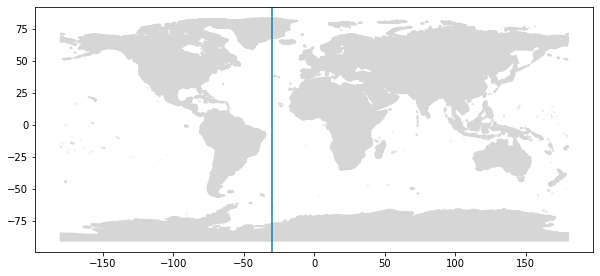

In [39]:
# quickly finding the limits that are of owr interest
fig,ax=plt.subplots(figsize=(10,4.5))
for loc in contpolygons.keys():
    ax.add_collection(PatchCollection(contpolygons[loc],facecolor='#d6d6d6',edgecolor='#d6d6d6',alpha=1,linewidth=2))        
    ax.plot()
ax.axvline(-30,-75,75)
plt.show()

In [40]:
len(lepido['species'].unique())/3

12.666666666666666

## 4. Plot hexagon bins calculated from the density of GBIF records in a particular area

We lost *Raphia rostrata* with the cleaning

In [41]:
lepido[lepido['spp_assigned'].str.contains('rostrata')]

,index,Unnamed: 0,X,basisOfRecord,catalogNumber,class,collectionCode,coordinatePrecision,coordinateUncertaintyInMeters,countryCode,...,speciesKey,spp_assigned,stateProvince,taxonKey,taxonRank,typeStatus,verbatimScientificName,verbatimScientificNameAuthorship,year,countryCode.1


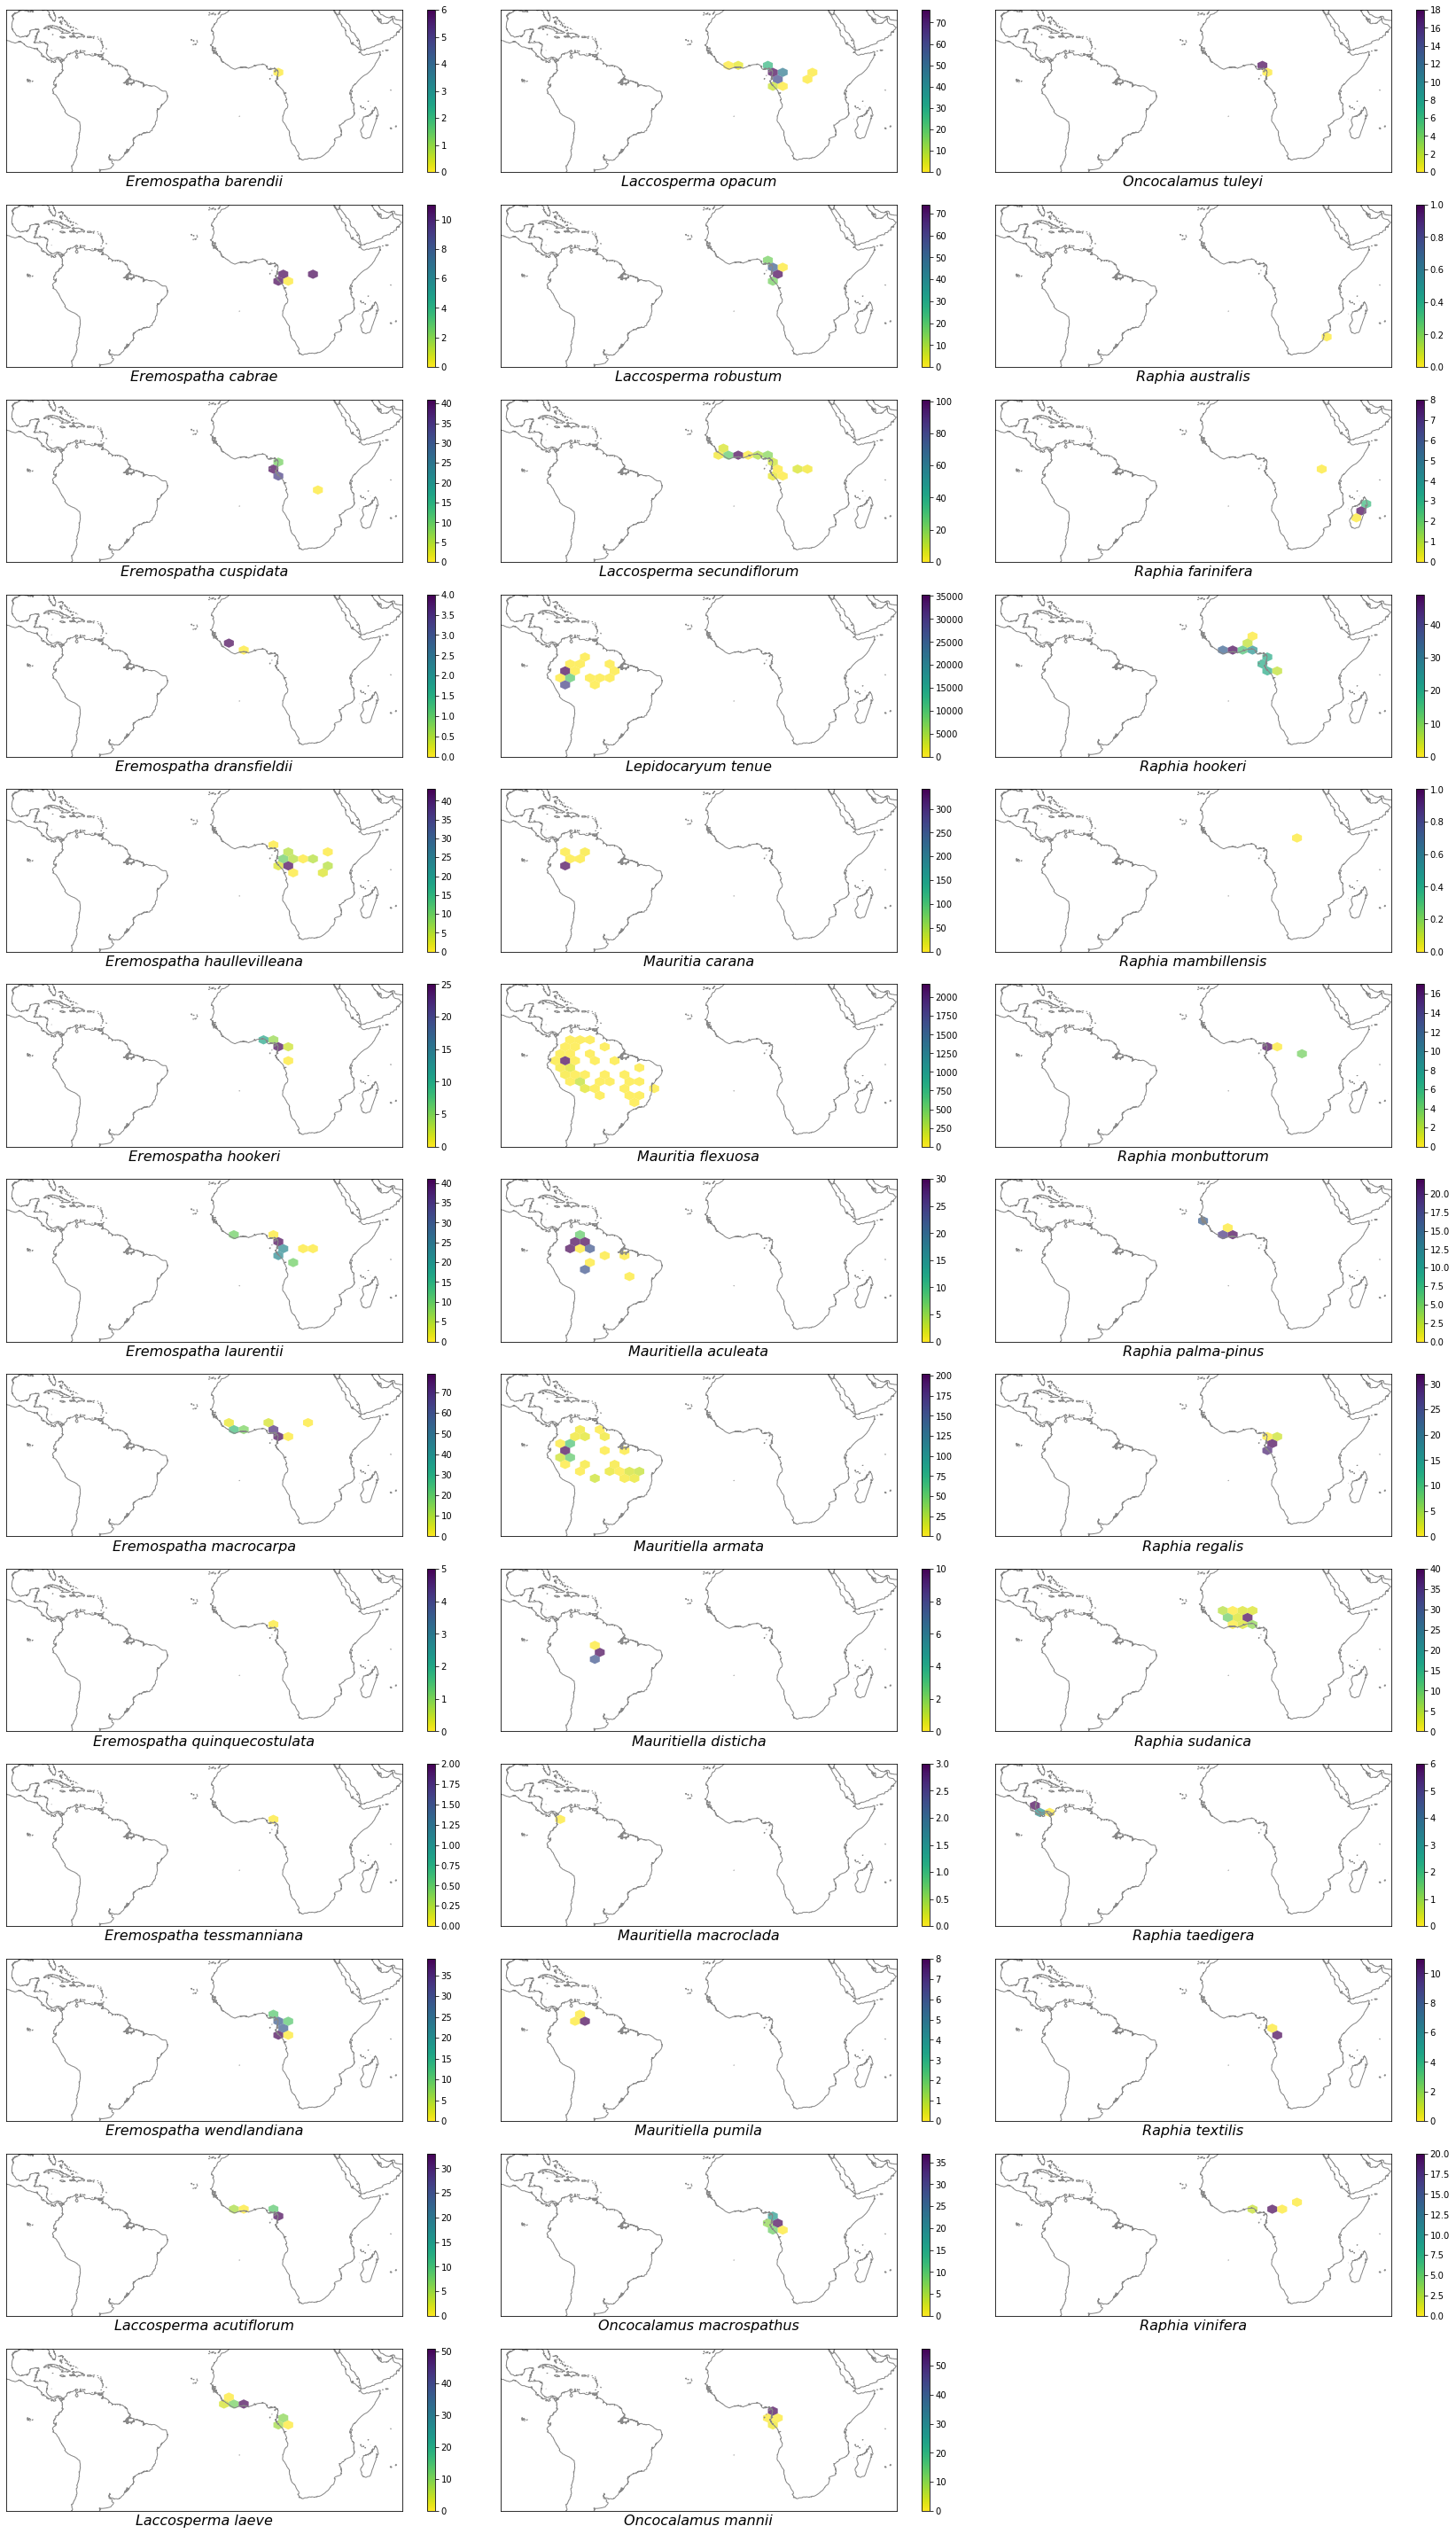

In [42]:
# gridspec. enumerate species. If index is odd place in 1 column, if even place in 0 column
fig=plt.figure(figsize=(10*3,4*15),facecolor='w')
# fig.suptitle('Correlations between Bio variables', size=20,y=0.9)
outer_grid=gridspec.GridSpec(15,3, wspace=0, hspace=0.2)

for j,(c,d) in enumerate(product([x for x in range(0,3)],[x for x in range(0,13)])):
    spp=sorted(list(lepido['spp_assigned'].unique()))[j]
    temp=lepido[lepido['spp_assigned']==spp]
    ax=plt.subplot(outer_grid[d,c])
    ax.hexbin(temp['decimalLongitude'],temp['decimalLatitude'],cmap='viridis_r',alpha=0.7,mincnt=1,edgecolor='none',gridsize=(50,int(50*0.2)),extent=(-100,100,-30,30)) #  (left, right, bottom, top)
    
    for loc in contpolygons.keys():
        ax.add_collection(PatchCollection(contpolygons[loc],facecolor='none',edgecolor='#878787',alpha=1,linewidth=1,label=loc,zorder=1))
        ax.plot
    ax.set_xticklabels([]) ; ax.set_yticklabels([])
    ax.set_xlabel(spp.replace('_',' '),fontstyle='italic',fontsize=16)
    ax.set_ylim(-40,30);ax.set_xlim(-100,60)
    norm = mpl.colors.Normalize(vmin=0, vmax=len(temp['decimalLongitude']))
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis_r'),ax=ax)
    plt.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelbottom=False)
# plt.savefig('./Lep_mapsallspp_20201022.pdf',pdi=300)
plt.show()

## 5. Adding GBIF coordinates from records

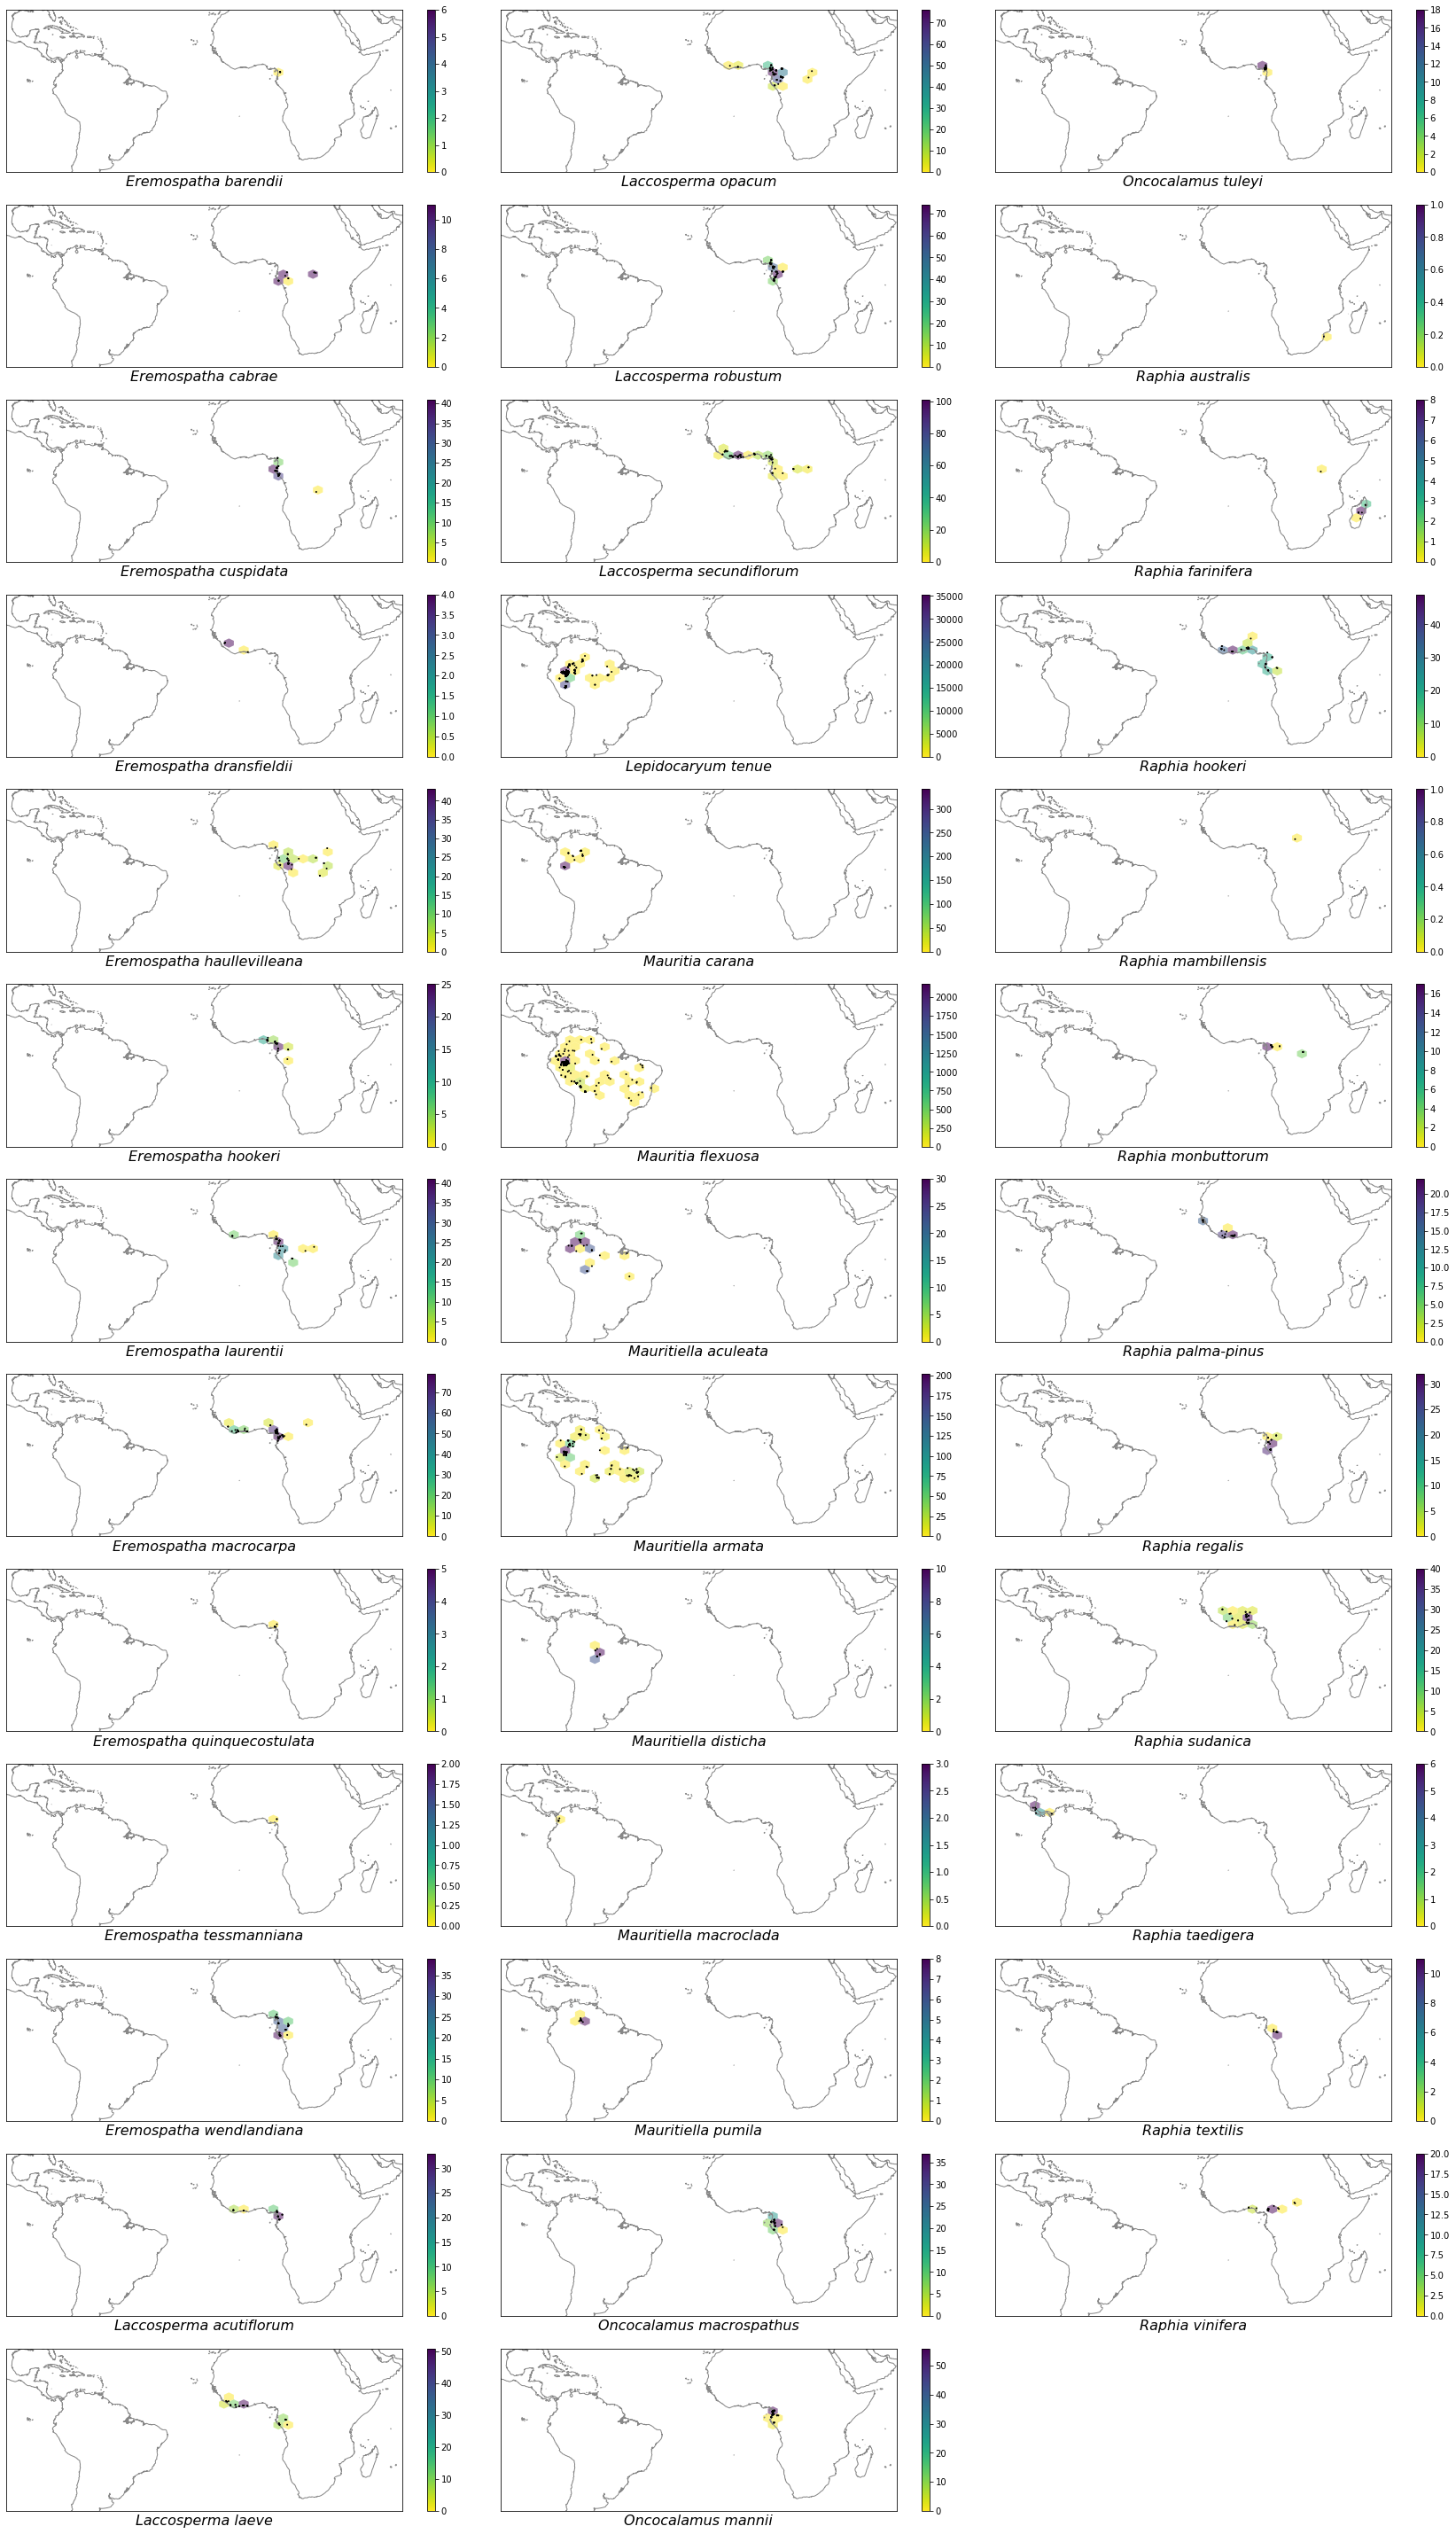

In [44]:
# gridspec. enumerate species. If index is odd place in 1 column, if even place in 0 column
fig=plt.figure(figsize=(10*3,4*15),facecolor='w')
# fig.suptitle('Correlations between Bio variables', size=20,y=0.9)
outer_grid=gridspec.GridSpec(15,3, wspace=0, hspace=0.2)

for j,(c,d) in enumerate(product([x for x in range(0,3)],[x for x in range(0,13)])):
    spp=sorted(list(lepido['spp_assigned'].unique()))[j]
    temp=lepido[lepido['spp_assigned']==spp]
    y=temp['decimalLatitude']
    x=temp['decimalLongitude']
#     if spp == 'Mauritiella_disticha':
#         print(x,y)
#         ax.text(x,y,'%s_%s'%(x,y))
#         x=alldata[alldata['species']=='Mauritiella_disticha']['decimalLongitude']
#         y=alldata[alldata['species']=='Mauritiella_disticha']['decimalLatitude']
    ax=plt.subplot(outer_grid[d,c])
    ax.hexbin(temp['decimalLongitude'],temp['decimalLatitude'],cmap='viridis_r',alpha=0.5,mincnt=1,edgecolor='none',gridsize=(50,int(50*0.2)),extent=(-100,100,-30,30)) #  (left, right, bottom, top)
    ax.scatter(x,y,s=4,facecolor='k',edgecolor='none',zorder=10)

    for loc in contpolygons.keys():
        ax.add_collection(PatchCollection(contpolygons[loc],facecolor='none',edgecolor='#878787',alpha=1,linewidth=1,label=loc,zorder=1))
        ax.plot
    ax.set_xticklabels([]) ; ax.set_yticklabels([])
    ax.set_xlabel(spp.replace('_',' '),fontstyle='italic',fontsize=16)
    ax.set_ylim(-40,30);ax.set_xlim(-100,60)
    norm = mpl.colors.Normalize(vmin=0, vmax=len(temp['decimalLongitude']))
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis_r'),ax=ax)
    plt.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelbottom=False)
# plt.savefig('./Lep_mapsallspp_20210305.pdf',pdi=300)
plt.show()

In [50]:
lepido['identifiedBy'].unique()

array(['Paquilé Chérif', 'Couvreur, TLP', 'Valkenburg, JLCH van',
       'G.Mann et H.Wendl.', 'A.Chev.', 'P.Beauv.', 'Koning J de',
       'Mogue Kamga S', 'Wieringa JJ; Mogue Kamga S',
       'Valkenburg JLCH van', 'C.C.H. Jongkind', 'Couvreur TLP',
       'L. Aké-Assi', 'Felix Forest', 'Jongkind CCH', 'R.G.S., A.A.H.',
       'Adjakidjè 3904', 'Houngnon 4437', 'De Souza 1453 a',
       'De Souza & Paradis 1453 c', 'De Souza 1453b',
       'Éq. Bot. UNB 1453d', 'RRC ID Flag', 'M.H. Grayum (MO)',
       'R. E. Gereau', 'Dransfield, J.', 'Polé P', 'Raynal',
       'M.H. Grayum', 'D.L. Spellman', 'R. Robles, VI/',
       'J.L.C.H. van Valkenburg', 'Tuley P', 'Bayton R.P.',
       'Dransfield, J.; Beentje, H.', 'Bayton, R.P.', 'R. Bernal',
       'Maesen LJG van der', 'Kruif APM de', 'Bako BG', 'Russell TA',
       'Sainge', 'Andel TR van', 'Aké Assi, L.', 'TOGNI Yolande',
       'Luís Catarino', 'Lidwine Egnomby DOSSOU', 'Badjito Prudence S.',
       'Mogue Kamga, S.', 'Couvreur, T.L.P.

In [51]:
remove_identby = [ 'RRC ID Flag', 'SNR', np.nan]

lepidoclean =  lepido[~lepido['identifiedBy'].isin(remove_identby)]
lepidoclean

,index,Unnamed: 0,X,basisOfRecord,catalogNumber,class,collectionCode,coordinatePrecision,coordinateUncertaintyInMeters,countryCode,...,speciesKey,spp_assigned,stateProvince,taxonKey,taxonRank,typeStatus,verbatimScientificName,verbatimScientificNameAuthorship,year,countryCode.1
0,0.0,1.0,0.0,HUMAN_OBSERVATION,PCBMN_383,Liliopsida,PCBMN,NaN,NaN,GN,...,5293204.0,Raphia_palma-pinus,Lola,5293209.0,SPECIES,NaN,Raphia gracilis,Beck,NaN,GIN
1,1.0,2.0,1.0,HUMAN_OBSERVATION,PCBMN_384,Liliopsida,PCBMN,NaN,NaN,GN,...,5293235.0,Raphia_hookeri,Lola,5293235.0,SPECIES,NaN,Raphia hookeri,G. Mann et H. Wendl,NaN,GIN
2,6.0,7.0,6.0,PRESERVED_SPECIMEN,4470276,Liliopsida,Herbier National du Gabon,0.00017,NaN,GA,...,5293258.0,Raphia_regalis,Woleu-Ntem,5293258.0,SPECIES,NaN,Raphia regalis Becc.,NaN,2015.0,GAB
3,7.0,8.0,7.0,PRESERVED_SPECIMEN,3457,Liliopsida,Herbier National du Gabon,0.01667,NaN,GA,...,5293235.0,Raphia_hookeri,Haut-Ogooué,5293235.0,SPECIES,NaN,Raphia hookeri G.Mann & H.Wendl.,NaN,1992.0,GAB
4,8.0,9.0,8.0,PRESERVED_SPECIMEN,189958,Liliopsida,Herbier National du Gabon,0.00167,NaN,GA,...,5293235.0,Raphia_hookeri,Estuaire,5293235.0,SPECIES,NaN,Raphia hookeri G.Mann & H.Wendl.,NaN,1990.0,GAB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39060,39420.0,39641.0,39640.0,PRESERVED_SPECIMEN,02622968,Liliopsida,NY,NaN,NaN,BR,...,2732630.0,Lepidocaryum_tenue,Pará,2732630.0,SPECIES,NaN,Lepidocaryum tenue Mart.,Mart.,2011.0,BRA
39061,39424.0,39645.0,39644.0,PRESERVED_SPECIMEN,K000208488,Liliopsida,Herbarium,NaN,NaN,PE,...,2732630.0,Lepidocaryum_tenue,NaN,7227435.0,VARIETY,NaN,Lepidocaryum tenue Mart. var. tenue,Mart.,2001.0,PER
39062,39427.0,39648.0,39647.0,PRESERVED_SPECIMEN,286476,Liliopsida,MO,NaN,NaN,PE,...,2732630.0,Lepidocaryum_tenue,Loreto,2732630.0,SPECIES,NaN,Lepidocaryum tenue Mart.,Mart.,1991.0,PER
39063,39428.0,39649.0,39648.0,PRESERVED_SPECIMEN,286412,Liliopsida,MO,NaN,NaN,CO,...,2732630.0,Lepidocaryum_tenue,Amazonas,2732630.0,SPECIES,NaN,Lepidocaryum tenue Mart.,Mart.,1992.0,COL


# Cleanest version for all Lepidocaryeae

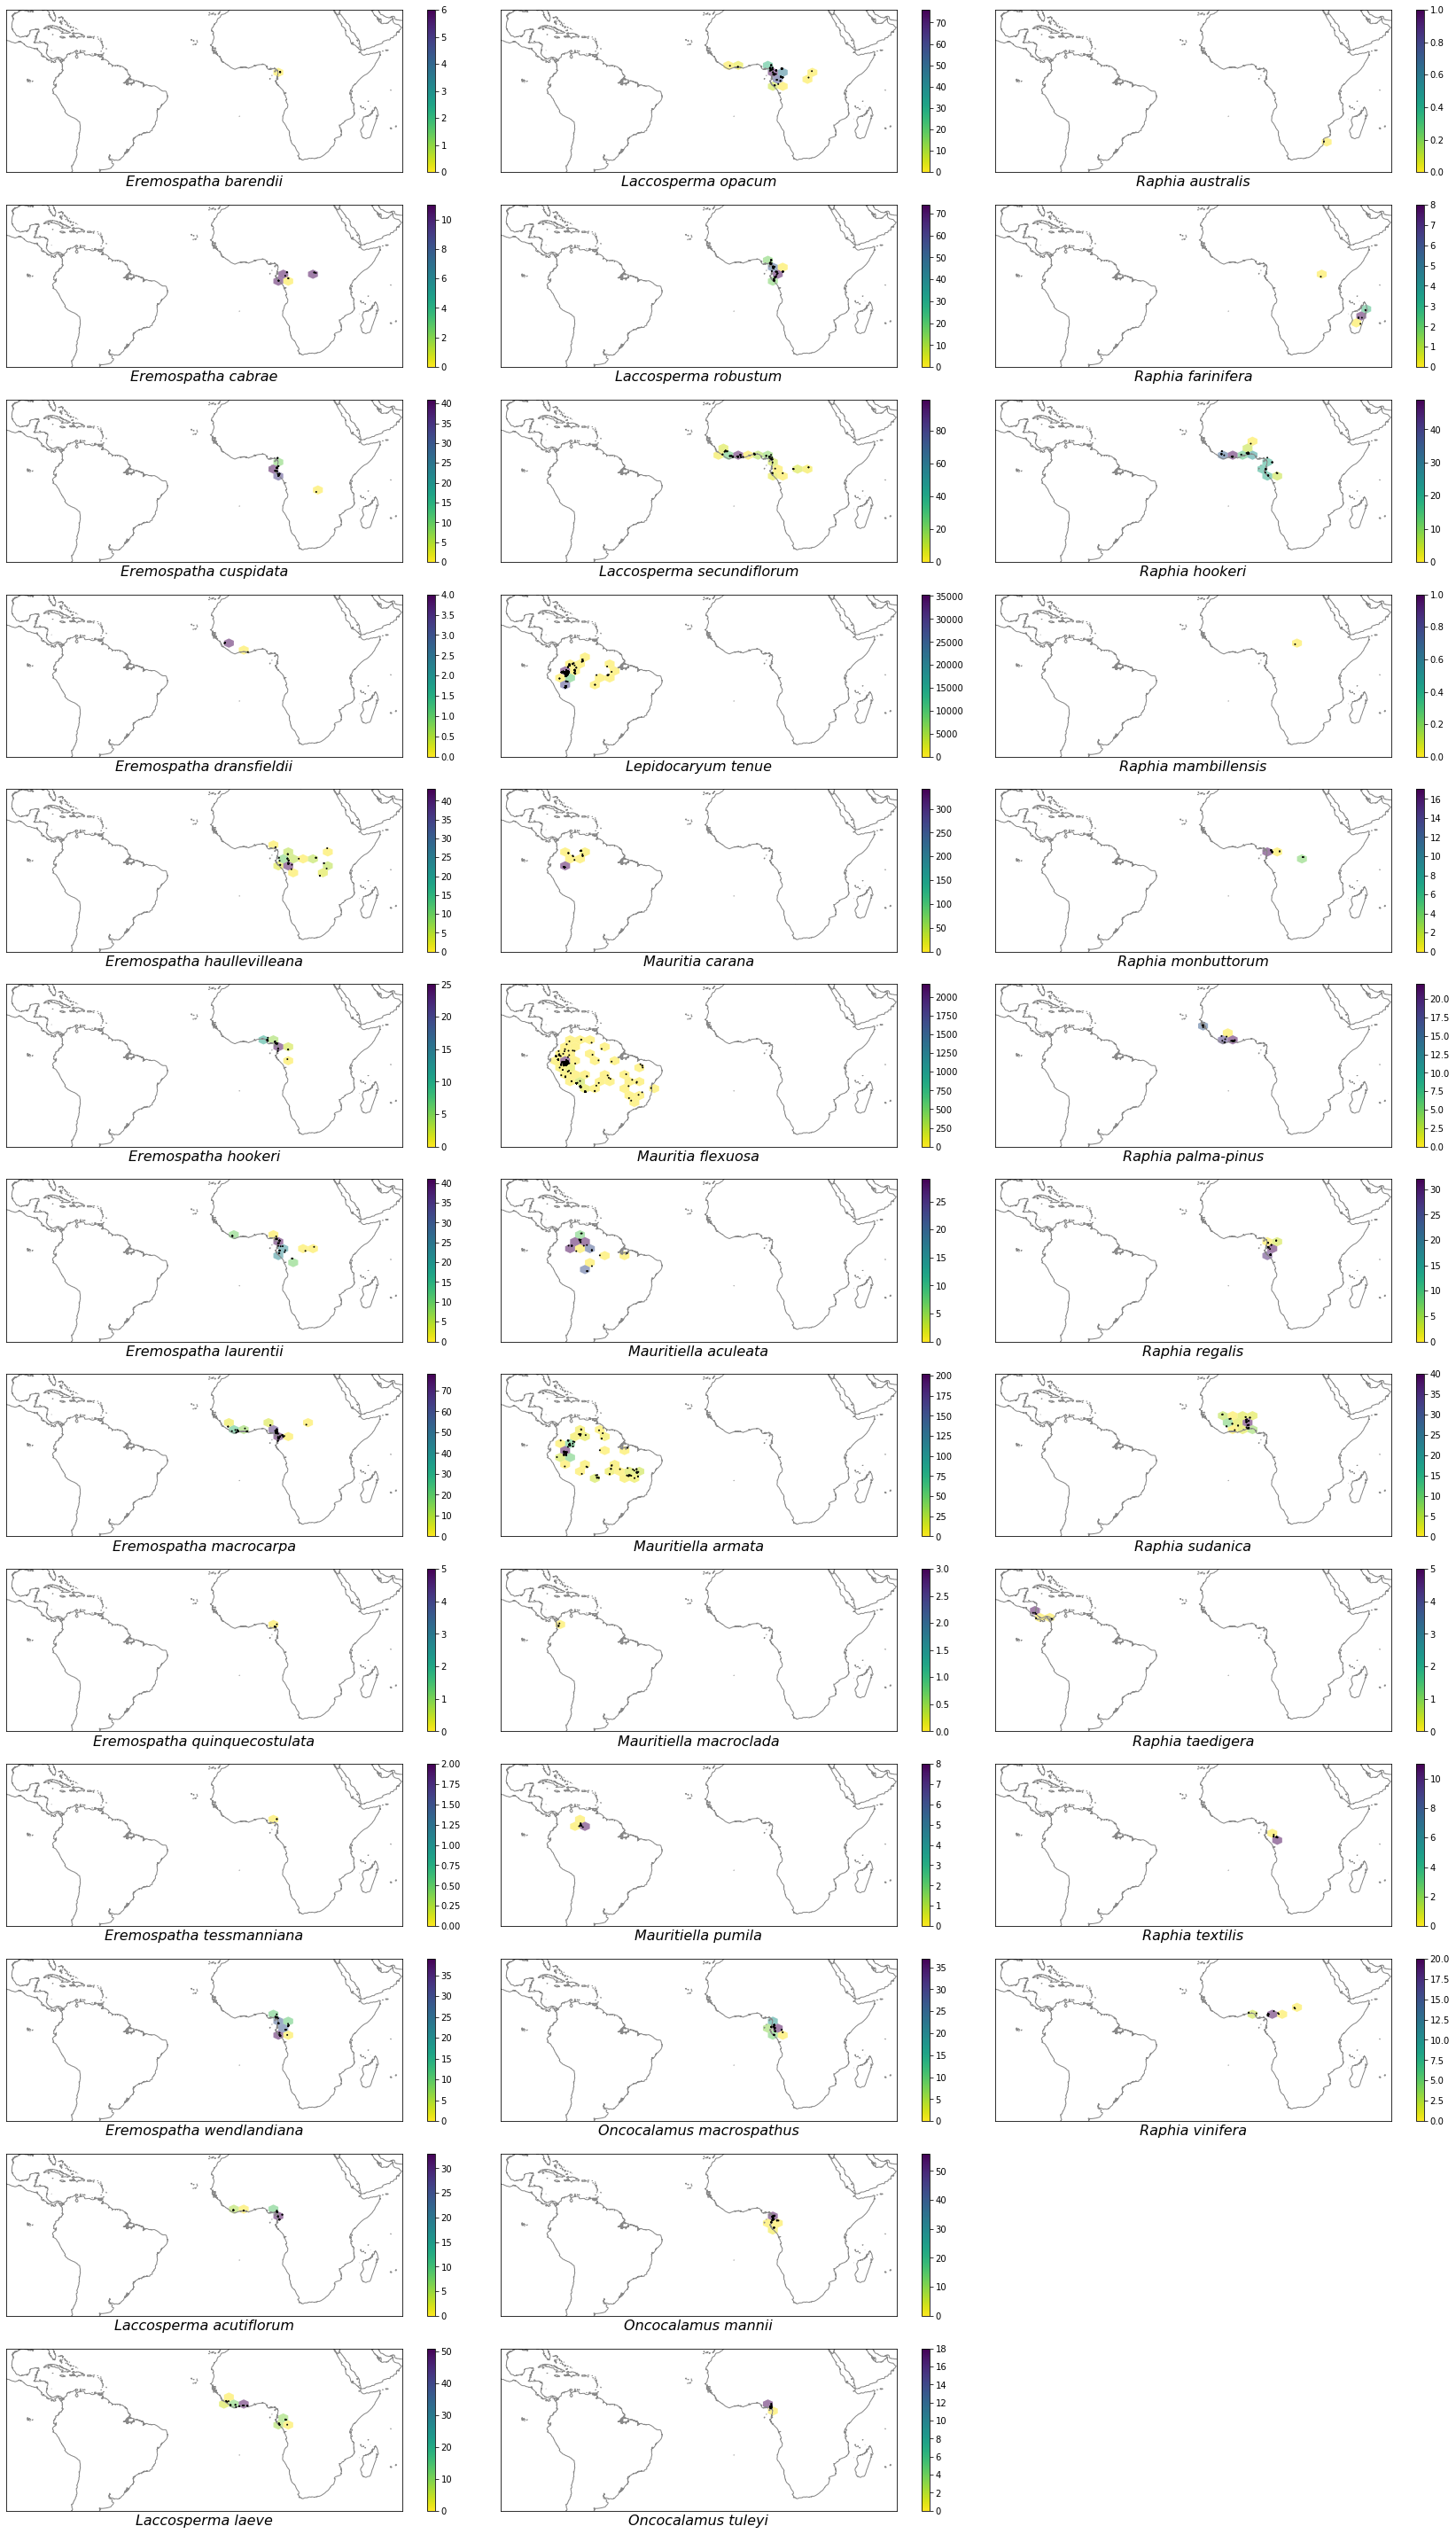

In [54]:
# gridspec. enumerate species. If index is odd place in 1 column, if even place in 0 column
fig=plt.figure(figsize=(10*3,4*15),facecolor='w')
# fig.suptitle('Correlations between Bio variables', size=20,y=0.9)
outer_grid=gridspec.GridSpec(15,3, wspace=0, hspace=0.2)

for j,(c,d) in enumerate(product([x for x in range(0,3)],[x for x in range(0,13)])):
    spp=sorted(list(lepidoclean['spp_assigned'].unique()))[j]
    temp=lepidoclean[lepidoclean['spp_assigned']==spp]
    y=temp['decimalLatitude']
    x=temp['decimalLongitude']
#     if spp == 'Mauritiella_disticha':
#         print(x,y)
#         ax.text(x,y,'%s_%s'%(x,y))
#         x=alldata[alldata['species']=='Mauritiella_disticha']['decimalLongitude']
#         y=alldata[alldata['species']=='Mauritiella_disticha']['decimalLatitude']
    ax=plt.subplot(outer_grid[d,c])
    ax.hexbin(temp['decimalLongitude'],temp['decimalLatitude'],cmap='viridis_r',alpha=0.5,mincnt=1,edgecolor='none',gridsize=(50,int(50*0.2)),extent=(-100,100,-30,30)) #  (left, right, bottom, top)
    ax.scatter(x,y,s=4,facecolor='k',edgecolor='none',zorder=10)

    for loc in contpolygons.keys():
        ax.add_collection(PatchCollection(contpolygons[loc],facecolor='none',edgecolor='#878787',alpha=1,linewidth=1,label=loc,zorder=1))
        ax.plot
    ax.set_xticklabels([]) ; ax.set_yticklabels([])
    ax.set_xlabel(spp.replace('_',' '),fontstyle='italic',fontsize=16)
    ax.set_ylim(-40,30);ax.set_xlim(-100,60)
    norm = mpl.colors.Normalize(vmin=0, vmax=len(temp['decimalLongitude']))
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis_r'),ax=ax)
    plt.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelbottom=False)
plt.savefig('./Lep_mapsallspp_20210417.pdf',pdi=300)
plt.show()

## 6. Plotting *Mauritiella*

In [45]:
mauritiella=lepido[(lepido['genus']=='Mauritiella') & (lepido['identifiedBy']!='RRC ID Flag')] #
mauritiella.columns
mauritiella.to_csv('./mauritiella_gbif_20210305.csv',sep=',')
mauritiella['identifiedBy'].unique()

array(['H. Balslev', 'D.K.Andersen', 'H.Balslev', 'T.Kristiansen',
       'T.Kristiansen and H.Balslev', 'Henrik Balslev', 'L. R. Noblick',
       'Henderson, A.', 'A. J. Henderson', 'M. Moraes R.',
       'R. Bernal (COL)', 'FVG (A. Henderson)', 'A. Henderson (NY)',
       'L.R.Noblick', 'F. Kahn', 'González, M.F.', 'Marín, C.',
       'Martins, RC', 'Lima, GP', 'Souza, FG', 'M. Simon', 'G. P. Lima',
       'B. M. T. Walter', 'Misas-Urreta G', 'Silva, CAS da',
       'N. Ritter (NHA)', 'J. C. Betancur', 'R. Beral (COL)',
       'Al Gentry (MO)', 'A. Henderson', 'A. Z.', 'Cordero-P., Z.',
       'Cárdenas, D.', 'Bernal, R.', 'Suárez, S.', 'Aguirre-S., J.',
       'Jaimes-R., M.S.', 'Bernal González, Rodrigo',
       'S. Altamirano (BOLV)', 'Henderson, A', 'Henderson, A.J.',
       'Engels, M.E.', 'Guedes, ML', 'Noblick, LR', 'E. J. Ferreira',
       'W. J. Baker', 'Brotto, M.L.', 'Ferreira, E.', 'Juan Copete',
       'Marcato, AC', 'Baker, W', 'L.C. Bernacci', 'M. Moraes Ramírez',
    

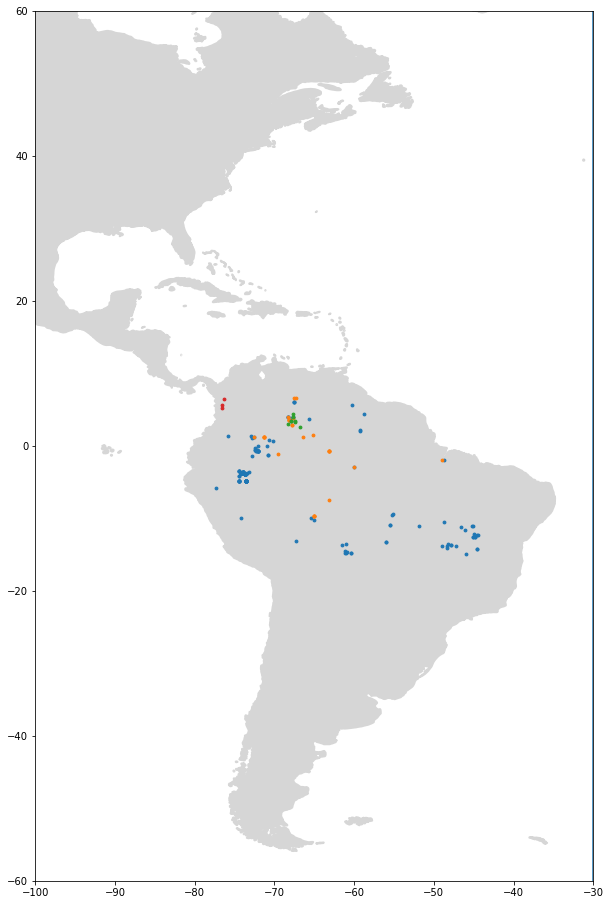

In [46]:
# quickly checking where things fall
fig,ax=plt.subplots(figsize=(10,16))
for loc in contpolygons.keys():
    ax.add_collection(PatchCollection(contpolygons[loc],facecolor='#d6d6d6',edgecolor='#d6d6d6',alpha=1,linewidth=2))        
    ax.plot()
for spp in mauritiella['spp_assigned'].unique():
    temp=mauritiella[mauritiella['spp_assigned']==spp]
    ax.scatter(temp['decimalLongitude'],temp['decimalLatitude'],s=8)
ax.axvline(-30,-75,75)
ax.set_xlim(-100,-30)
ax.set_ylim(-60,60)
plt.show()

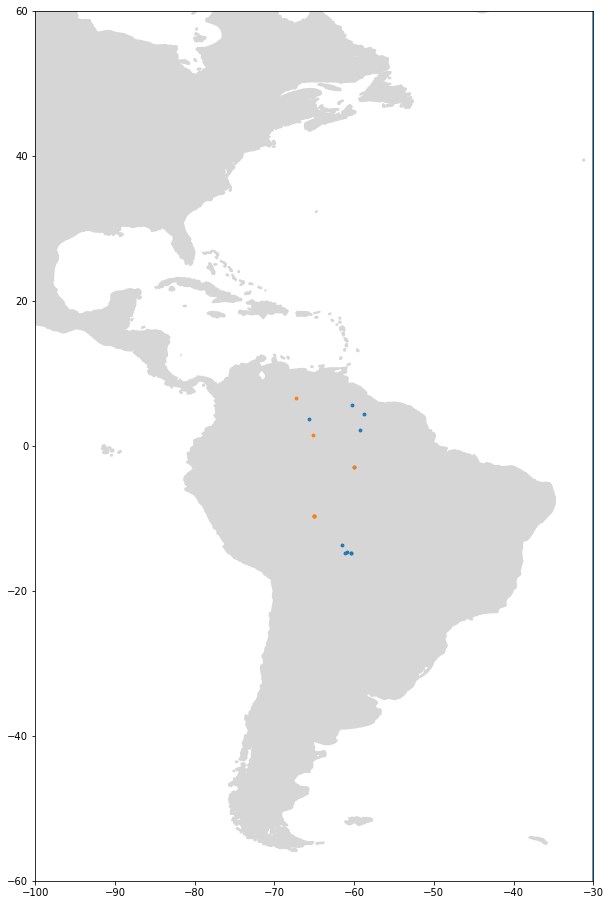

In [48]:
# only A. Henderson's identified records:
# and the reason why sticking to a single expert isn't the best idea. Others are good too.
sub=mauritiella[mauritiella['identifiedBy'].str.contains('Henderson')]

fig,ax=plt.subplots(figsize=(10,16))
for loc in contpolygons.keys():
    ax.add_collection(PatchCollection(contpolygons[loc],facecolor='#d6d6d6',edgecolor='#d6d6d6',alpha=1,linewidth=2))        
    ax.plot()
for spp in sub['spp_assigned'].unique():
    temp=sub[sub['spp_assigned']==spp]
    ax.scatter(temp['decimalLongitude'],temp['decimalLatitude'],s=8)
ax.axvline(-30,-75,75)
ax.set_xlim(-100,-30)
ax.set_ylim(-60,60)
plt.show()

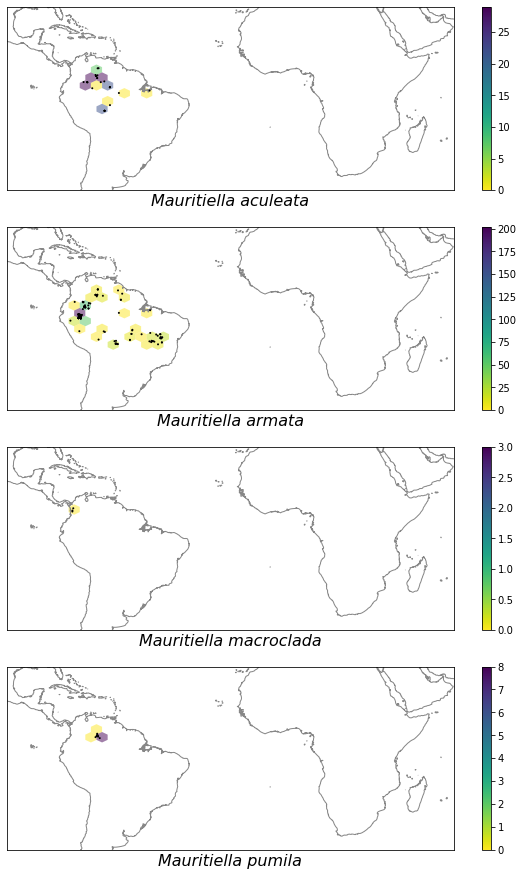

In [49]:
# gridspec. enumerate species. If index is odd place in 1 column, if even place in 0 column
fig=plt.figure(figsize=(10*3,4*15),facecolor='w')
# fig.suptitle('Correlations between Bio variables', size=20,y=0.9)
outer_grid=gridspec.GridSpec(15,3, wspace=0, hspace=0.2)

for j,(c,d) in enumerate(product([x for x in range(0,3)],[x for x in range(0,13)])):
    spp=sorted(list(mauritiella['spp_assigned'].unique()))[j]
    temp=mauritiella[mauritiella['spp_assigned']==spp]
    y=temp['decimalLatitude']
    x=temp['decimalLongitude']
#     if spp == 'Mauritiella_disticha':
#         print(x,y)
#         ax.text(x,y,'%s_%s'%(x,y))
#         x=alldata[alldata['species']=='Mauritiella_disticha']['decimalLongitude']
#         y=alldata[alldata['species']=='Mauritiella_disticha']['decimalLatitude']
    ax=plt.subplot(outer_grid[d,c])
    ax.hexbin(temp['decimalLongitude'],temp['decimalLatitude'],cmap='viridis_r',alpha=0.5,mincnt=1,edgecolor='none',gridsize=(50,int(50*0.2)),extent=(-100,100,-30,30)) #  (left, right, bottom, top)
    ax.scatter(x,y,s=4,facecolor='k',edgecolor='none',zorder=10)

    for loc in contpolygons.keys():
        ax.add_collection(PatchCollection(contpolygons[loc],facecolor='none',edgecolor='#878787',alpha=1,linewidth=1,label=loc,zorder=1))
        ax.plot
    ax.set_xticklabels([]) ; ax.set_yticklabels([])
    ax.set_xlabel(spp.replace('_',' '),fontstyle='italic',fontsize=16)
    ax.set_ylim(-40,30);ax.set_xlim(-100,60)
    norm = mpl.colors.Normalize(vmin=0, vmax=len(temp['decimalLongitude']))
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis_r'),ax=ax)
    plt.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelbottom=False)
# plt.savefig('./Lep_mapsallspp_20210305.pdf',pdi=300)
plt.show()